In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [99]:
data = pd.read_csv('../ssd_data/imputated_data/imputated_data_MB1.csv')
# 'index' 컬럼을 datetime 형태로 변환
data['index'] = pd.to_datetime(data['index'])

data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,31346.0,100.0,0.0,97.0,12769.0,99.0,13.0,99.0,31.0,...,28.0,200.0,0.0,100.0,0.0,99.0,3.003245e+10,99.0,2.761588e+10,0.0
1,2019-01-02,31346.0,100.0,0.0,97.0,12792.0,99.0,13.0,99.0,31.0,...,28.0,200.0,0.0,100.0,0.0,99.0,3.058151e+10,99.0,2.778027e+10,0.0
2,2019-01-03,31346.0,100.0,0.0,97.0,12816.0,99.0,13.0,99.0,31.0,...,28.0,200.0,0.0,100.0,0.0,99.0,3.106840e+10,99.0,2.795260e+10,0.0
3,2019-01-04,31346.0,100.0,0.0,97.0,12840.0,99.0,13.0,99.0,32.0,...,28.0,200.0,0.0,100.0,0.0,99.0,3.144897e+10,99.0,2.812494e+10,0.0
4,2019-01-05,31346.0,100.0,0.0,97.0,12864.0,99.0,13.0,99.0,32.0,...,28.0,200.0,0.0,100.0,0.0,99.0,3.179422e+10,99.0,2.829816e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50313,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
50314,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
50315,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
50316,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [100]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(139, 1)

In [101]:
# disk_ids 데이터프레임에 있는 disk_id와 일치하는 행을 data 데이터프레임에서 불러옴
selected_label_1 = data[data['disk_id'].isin(selected_disk_model_1['disk_id'])]

# ds 컬럼에 따라 정렬
selected_label_1 = selected_label_1.sort_values(by=['disk_id','index'])
# 결과 출력
selected_label_1

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
43078,2019-01-01,531.0,100.0,0.0,97.0,14770.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601918e+11,99.0,1.282129e+12,0.0
43079,2019-01-02,531.0,100.0,0.0,97.0,14794.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601918e+11,99.0,1.282129e+12,0.0
43080,2019-01-03,531.0,100.0,0.0,97.0,14818.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
43081,2019-01-04,531.0,100.0,0.0,97.0,14842.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
43082,2019-01-05,531.0,100.0,0.0,97.0,14866.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32756,2019-06-26,44338.0,99.0,2.0,96.0,18504.0,99.0,21.0,99.0,9.0,...,30.0,200.0,0.0,100.0,0.0,99.0,1.395901e+10,99.0,9.413844e+09,0.0
32757,2019-06-27,44338.0,99.0,2.0,96.0,18528.0,99.0,21.0,99.0,9.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.395920e+10,99.0,9.413844e+09,0.0
32758,2019-06-28,44338.0,99.0,2.0,96.0,18552.0,99.0,21.0,99.0,9.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.396014e+10,99.0,9.413844e+09,0.0
32759,2019-06-29,44338.0,99.0,2.0,96.0,18576.0,99.0,21.0,99.0,9.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.396116e+10,99.0,9.413844e+09,0.0


In [102]:
remove_indexes = []
for index, row in selected_label_1.iterrows():
    if row['label'] == 1:
        disk_id = row['disk_id']
        ds = row['index']
        remove_indexes.extend(selected_label_1.index[(selected_label_1['disk_id'] == disk_id) & (selected_label_1['index'] > ds)].tolist())

# 중복된 인덱스를 제거하여 제거할 행들을 구함
remove_indexes = list(set(remove_indexes))

# 제거할 행을 제외한 최종 DataFrame을 생성
del_fail_after_row = selected_label_1.drop(index=remove_indexes)

# 결과 출력
del_fail_after_row

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
43078,2019-01-01,531.0,100.0,0.0,97.0,14770.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601918e+11,99.0,1.282129e+12,0.0
43079,2019-01-02,531.0,100.0,0.0,97.0,14794.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601918e+11,99.0,1.282129e+12,0.0
43080,2019-01-03,531.0,100.0,0.0,97.0,14818.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
43081,2019-01-04,531.0,100.0,0.0,97.0,14842.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
43082,2019-01-05,531.0,100.0,0.0,97.0,14866.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32659,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0
32660,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0
32661,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0
32662,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0


In [103]:
del_fail_after_row.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14199 entries, 43078 to 32663
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    14199 non-null  datetime64[ns]
 1   disk_id  14199 non-null  float64       
 2   n_5      14199 non-null  float64       
 3   r_5      14199 non-null  float64       
 4   n_9      14199 non-null  float64       
 5   r_9      14199 non-null  float64       
 6   n_12     14199 non-null  float64       
 7   r_12     14199 non-null  float64       
 8   n_177    14199 non-null  float64       
 9   r_177    14199 non-null  float64       
 10  n_180    14199 non-null  float64       
 11  r_180    14199 non-null  float64       
 12  n_181    14199 non-null  float64       
 13  r_181    14199 non-null  float64       
 14  n_182    14199 non-null  float64       
 15  r_182    14199 non-null  float64       
 16  n_183    14199 non-null  float64       
 17  r_183    14199 non-null  fl

In [104]:
import pandas as pd

# 'index' 컬럼을 datetime 형태로 변환
del_fail_after_row['index'] = pd.to_datetime(del_fail_after_row['index'])

# 모든 행에 대해 반복
for index, row in del_fail_after_row.iterrows():
    # label 값이 1인 경우
    if row['label'] == 1:
        # 해당 행의 disk_id
        current_disk_id = row['disk_id']
        # 해당 행의 날짜
        current_date = row['index']
        # 30일 이전의 날짜 계산
        days_before = current_date - pd.Timedelta(days=30)
        
        # 같은 disk_id이면서, 날짜가 30일 이내인 행들을 찾아서 label 값을 1로 설정
        del_fail_after_row.loc[(del_fail_after_row['disk_id'] == current_disk_id) &
                             (del_fail_after_row['index'] <= current_date) &
                             (del_fail_after_row['index'] > days_before), 'label'] = 1

del_fail_after_row

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
43078,2019-01-01,531.0,100.0,0.0,97.0,14770.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601918e+11,99.0,1.282129e+12,0.0
43079,2019-01-02,531.0,100.0,0.0,97.0,14794.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601918e+11,99.0,1.282129e+12,0.0
43080,2019-01-03,531.0,100.0,0.0,97.0,14818.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
43081,2019-01-04,531.0,100.0,0.0,97.0,14842.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
43082,2019-01-05,531.0,100.0,0.0,97.0,14866.0,99.0,20.0,96.0,294.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.601919e+11,99.0,1.282129e+12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32659,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,1.0
32660,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,1.0
32661,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,1.0
32662,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,1.0


In [105]:
label_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)
label_1

,disk_id
0,531.0
1,601.0
2,1399.0
3,1408.0
4,1500.0
...,...
134,43191.0
135,43760.0
136,44330.0
137,44335.0


In [106]:
disk_list = list(data['disk_id'].drop_duplicates())
failure_disk_list = list(label_1.values.squeeze())
healthy_disk_list = list(set(disk_list) - set(failure_disk_list))

In [107]:
import random
random.seed(42)

# 100개씩 랜덤하게 선택
healthy_disk_100 = random.sample(healthy_disk_list, 100)
failure_disk_100 = random.sample(failure_disk_list, 100)

print(len(healthy_disk_100))
print(len(failure_disk_100))

# 39개씩 랜덤하게 선택
healthy_disk_39 = list(set(healthy_disk_list) - set(healthy_disk_100))
failure_disk_39 = list(set(failure_disk_list) - set(failure_disk_100))

print(len(healthy_disk_39))
print(len(failure_disk_39))

100
100
39
39


In [108]:
H_disk_100 = data[data['disk_id'].isin(healthy_disk_100)]
F_disk_100 = del_fail_after_row[del_fail_after_row['disk_id'].isin(failure_disk_100)]

H_disk_39 = data[data['disk_id'].isin(healthy_disk_39)]
F_disk_39 = del_fail_after_row[del_fail_after_row['disk_id'].isin(failure_disk_39)]

# train set , test set 생성
train_set = pd.concat([H_disk_100,F_disk_100],ignore_index=True,axis=0)
test_set = pd.concat([H_disk_39,F_disk_39],ignore_index=True,axis=0)

# feature와 label 구분
X_train = train_set.drop(columns=['disk_id','index','label'])
X_test = test_set.drop(columns=['disk_id','index','label'])

y_train = train_set['label']
y_test = test_set['label']

In [118]:
import numpy as np
def create_sequences(data, window_size):
    X = []
    y = []

    # 각 disk_id에 대해 처리
    for disk_id in data['disk_id'].unique():
        disk_data = data[data['disk_id'] == disk_id].sort_values('index')  # index로 정렬
        disk_values = disk_data.drop(columns=['disk_id', 'index']).values  # 'disk_id'와 'index' 컬럼을 제외하고 numpy array로 변환

        # 이 disk_id에 대해 시퀀스 생성
        for i in range(len(disk_values) - window_size):
            X.append(disk_values[i:i + window_size, :-1])  # 마지막 차원은 특성(feature)을 의미합니다. 마지막 열('fail')을 제외합니다.
            y.append(disk_values[i + window_size -1, -1])  # 예를 들어 'fail' 상태가 마지막 특성일 경우입니다.

    return np.array(X), np.array(y)

In [119]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
test_scaled = pd.concat([test_set[['disk_id','index']],X_test_scaled_df, y_test], axis=1)

In [193]:
window_size = 30 # 10일을 window로 설정합니다.
X_train_window, y_trian_window = create_sequences(train_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_test_window.shape)

print(y_trian_window.shape)
print(y_test_window.shape)


(22679, 30, 32)
(8503, 30, 32)
(22679,)
(8503,)


In [186]:
# 라이브러리 임포트
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from keras import regularizers

# LSTM 모델 정의
model = Sequential()
model.add(GRU(32, activation='relu', input_shape=(30, 32)))  # n_features는 특성의 수
model.add(Dense(32, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

# 학습
history = model.fit(X_train_window,y_trian_window, epochs=10, verbose=0,batch_size=32)

In [187]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


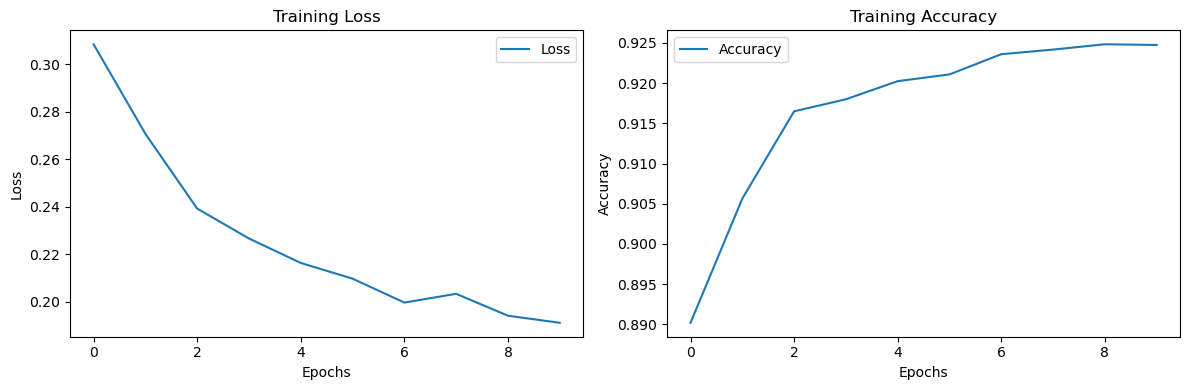

In [188]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그리기
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [189]:
model.evaluate(X_test_window,y_test_window)

266/266 [==============================] - 1s 3ms/step - loss: 0.1938 - acc: 0.9354


[0.19383841753005981, 0.9354345798492432]

In [190]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'F1 Score: {f1}')

266/266 [==============================] - 1s 3ms/step
F1 Score: 0.7908171626155795


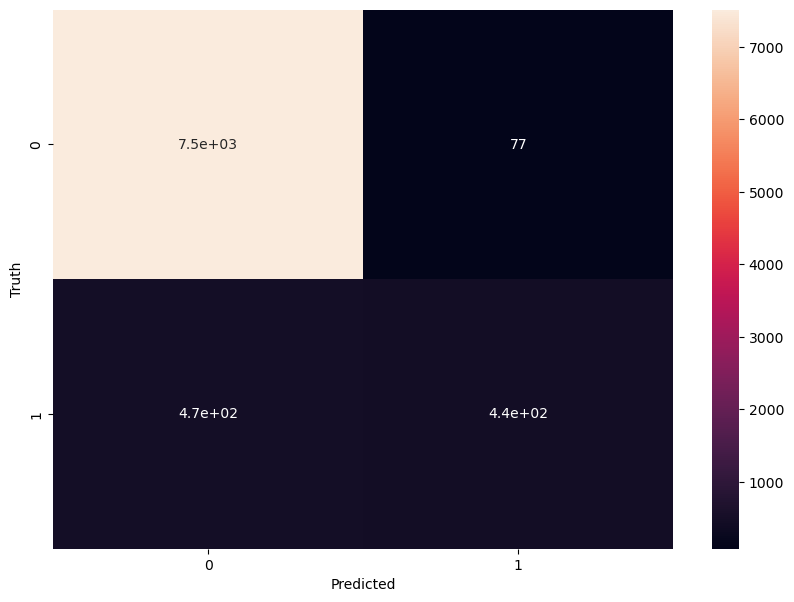

In [191]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [179]:
print(y_test.shape)
print(y_test[y_test.values==1].shape)

(10778,)
(1105,)


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
